In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg 
import kwant
from matplotlib.colors import LogNorm


In [2]:
def berry_curvature(syst, p, ks, num_filled_bands=1):
    """Berry curvature of a system.

    Parameters:
    -----------
    sys : kwant.Builder
        A 2D infinite system.
    p : dict
        The arguments expected by the system.
    ks : 1D array-like
        Values of momentum grid to be used for Berry curvature calculation.
    num_filled_bands : int
        The number of filled bands.

    Returns:
    --------
    bc : 2D array
        Berry curvature on each square in a `ks x ks` grid.
    """
    # Calculate an array of eigenvectors.
    B = np.array(syst.symmetry.periods).T
    A = B @ np.linalg.inv(B.T @ B)
    Kx, Ky = np.zeros([len(ks), len(ks)]), np.zeros([len(ks), len(ks)])
    syst = kwant.wraparound.wraparound(syst).finalized()

    def filled_states(kx, ky):
        k = np.array([kx, ky])
        kx, ky = np.linalg.solve(A, k)
        p.update(k_x=kx, k_y=ky)
        H = syst.hamiltonian_submatrix(params=p, sparse=False)
        return scipy.linalg.eigh(H)[1][:, :num_filled_bands]

    vectors = np.array(
        [[filled_states(kx, ky) for kx in ks] for ky in ks]
    )
    Kx = np.array(
        [[np.linalg.solve(A, np.array([kx, ky]))[0] for kx in ks] for ky in ks]
    )
    Ky = np.array(
        [[np.linalg.solve(A, np.array([kx, ky]))[1] for kx in ks] for ky in ks]
    )

    # The actual Berry curvature calculation
    vectors_x = np.roll(vectors, 1, 0)
    vectors_xy = np.roll(vectors_x, 1, 1)
    vectors_y = np.roll(vectors, 1, 1)

    shifted_vecs = [vectors, vectors_x, vectors_xy, vectors_y]

    v_shape = vectors.shape

    shifted_vecs = [i.reshape(-1, v_shape[-2], v_shape[-1]) for i in shifted_vecs]

    dets = np.ones(len(shifted_vecs[0]), dtype=complex)
    for vec, shifted in zip(shifted_vecs, np.roll(shifted_vecs, 1, 0)):
        dets *= [np.linalg.det(a.T.conj() @ b) for a, b in zip(vec, shifted)]
    bc = np.angle(dets).reshape(int(np.sqrt(len(dets))), -1)

    bc = (bc + np.pi / 2) % (np.pi) - np.pi / 2

    return bc, Kx, Ky


In [26]:
lat = kwant.lattice.honeycomb(a=1.0, norbs=1)
a, b = lat.sublattices

nnn_hoppings_a = (((-1, 0), a, a), ((0,  1), a, a), ((1, -1), a, a))
nnn_hoppings_b = ((( 1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

syst = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
syst[a(0, 0)] = lambda site, m, t2: m
syst[b(0, 0)] = lambda site, m, t2: -m
syst[lat.neighbors()] = -1
syst[lat_neighbors_2] = lambda site1, site2, m, t2: t2

# kwant.plot(syst, show=True)

In [29]:

ks = np.linspace(-np.pi, np.pi, 100)

bc0, Kx, Ky = berry_curvature(syst, dict(m=1.0, t2=0.15*np.exp(-1j*np.pi/3)), ks, num_filled_bands=1)

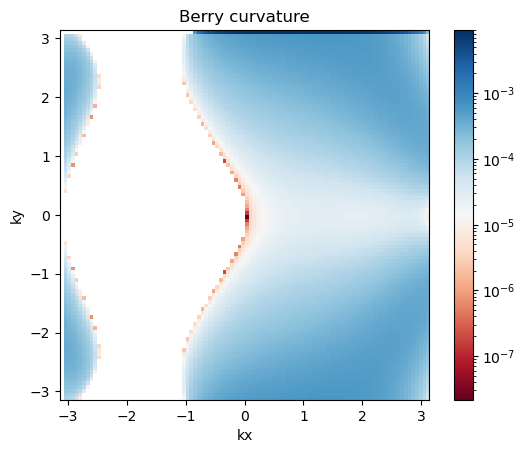

In [30]:
plt.imshow(
    bc0,
    cmap="RdBu",
    extent=(-np.pi, np.pi, -np.pi, np.pi),
    norm=LogNorm()
    # interpolation="bilinear"
)
plt.colorbar()
plt.title("Berry curvature")
plt.xlabel("kx")
plt.ylabel("ky")
plt.show()

In [31]:
bc0.sum()/(2*np.pi)

-2.6504622345529305e-15

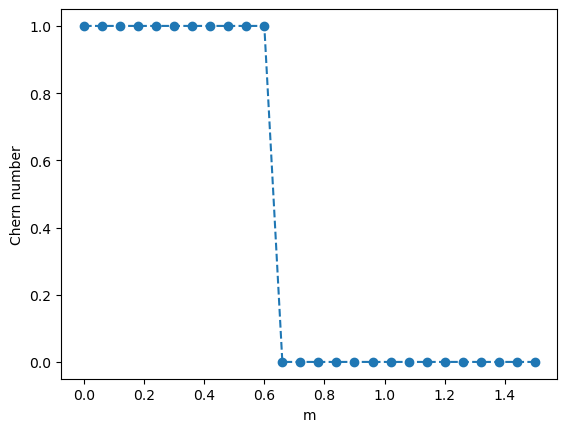

In [32]:
cherns = []
socs = np.linspace(0, 1e-2, 20)
ms = np.linspace(0, 1.5, 26)
for m_ in ms:
    bc = berry_curvature(syst, dict(m=m_, t2=0.15*np.exp(-1j*np.pi/3)), ks, num_filled_bands=1)[0]
    cherns.append(bc.sum()/np.pi/2)
plt.plot(ms, cherns, "o--")
# plt.xlabel("t_so")
plt.xlabel("m")
plt.ylabel("Chern number")
# plt.title("Chern number as a function of t_so")
plt.show()

In [39]:
for i in range(len(cherns)):
    print("m: ", np.round(ms[i], 3), "\tchern number: ", cherns[i])

m:  0.0 	chern number:  0.9999999999999988
m:  0.06 	chern number:  0.9999999999999978
m:  0.12 	chern number:  0.9999999999999994
m:  0.18 	chern number:  1.0000000000000002
m:  0.24 	chern number:  1.0000000000000013
m:  0.3 	chern number:  1.0000000000000002
m:  0.36 	chern number:  0.9999999999999979
m:  0.42 	chern number:  1.000000000000001
m:  0.48 	chern number:  1.0000000000000018
m:  0.54 	chern number:  0.9999999999999991
m:  0.6 	chern number:  0.9999999999999986
m:  0.66 	chern number:  9.54166404439055e-16
m:  0.72 	chern number:  -1.872993312417404e-15
m:  0.78 	chern number:  -1.1308638867425838e-15
m:  0.84 	chern number:  -1.8376538159566985e-15
m:  0.9 	chern number:  6.361109362927033e-16
m:  0.96 	chern number:  -1.3429008655068181e-15
m:  1.02 	chern number:  -6.361109362927033e-16
m:  1.08 	chern number:  6.007714398319976e-16
m:  1.14 	chern number:  1.872993312417404e-15
m:  1.2 	chern number:  1.766974823035287e-15
m:  1.26 	chern number:  2.8271597168564594e-

In [113]:
def energy_bands(sys: kwant.Builder, parameters: dict, plot=True):
    
    nbands = 2
    
    kx = np.linspace(0, 2*np.pi, 100)
    ky = np.linspace(0, 2*np.pi, 100)
    k_sys = kwant.wraparound.wraparound(sys).finalized()
    energies = np.zeros([len(kx), len(ky), nbands])
    for i in range(len(kx)):
        for j in range(len(ky)):
            parameters.update(k_x=kx[i], k_y=ky[j])
            h_k = k_sys.hamiltonian_submatrix(params=parameters, sparse=False)
            if i==0 and j==0: print(h_k)
            energies[i, j, :] = np.sort(np.real(np.linalg.eigvals(h_k)))

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    kx_grid, ky_grid = np.meshgrid(kx, ky)

    for n in range(nbands):
        E_vals=energies[:, :, n]
        ax.plot_surface(kx_grid, ky_grid, E_vals, cmap='viridis')

    ax.set_xlabel(r'$k_x$')
    ax.set_ylabel(r'$k_y$')
    ax.set_zlabel(r'Energy $E(k_x, k_y)$')

    plt.tight_layout()
    plt.show()
    return energies

In [ ]:
# %matplotlib qt
energies = energy_bands(syst, dict(m=0.6, t2=0.15*np.exp(-1j*np.pi/3)))

[[ 1.05+0.j -3.  +0.j]
 [-3.  -0.j -0.15+0.j]]


In [119]:
%matplotlib inline

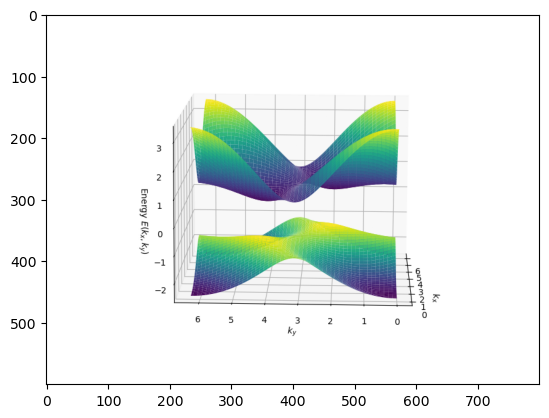

In [126]:
plt.imshow(plt.imread("/home/khaled-hasan/Downloads/Seminar Report/2Dgraphene-top.png", format="png"))

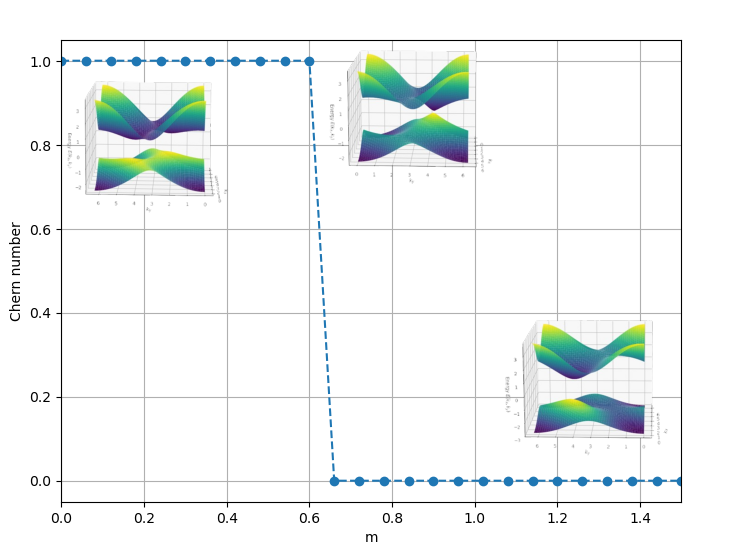

In [172]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig1, ax1 = plt.subplots(figsize=(8, 6))
plt.plot(ms, cherns, "o--")
plt.xlabel("m")
plt.ylabel("Chern number")
# plt.title("Chern number as a function of m")
plt.xlim(0, 1.5)
plt.grid()

inset_ax2 = fig1.add_axes([0.07, 0.55, 0.33, 0.33])
inset_ax2.imshow(plt.imread("/home/khaled-hasan/Downloads/Seminar Report/2Dgraphene-top-r.png", format="png"))
inset_ax2.axis("off")

inset_ax2 = fig1.add_axes([0.62, 0.15, 0.33, 0.33])
inset_ax2.imshow(plt.imread("/home/khaled-hasan/Downloads/Seminar Report/2Dgraphene-triv-r.png", format="png"))
inset_ax2.axis("off")

inset_ax2 = fig1.add_axes([0.40, 0.60, 0.33, 0.33])
inset_ax2.imshow(plt.imread("/home/khaled-hasan/Downloads/Seminar Report/2Dgraphene-trans-r.png", format="png"))
inset_ax2.axis("off")

plt.show()